# **Problem Statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


## Importing all the important libraries

In [1]:
# importing libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# suppressing tensorflow warnings. Only log the errors
import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
# checking the number of GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# downloading the data from the shared public google drive link
!gdown https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs

Downloading...
From: https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
To: /content/CNN_assignment.zip
100% 824M/824M [00:06<00:00, 127MB/s]


In [6]:
# unzipping the data
!unzip /content/CNN_assignment.zip

Archive:  /content/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer I

## Data Reading

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

## Data Understanding

In [8]:
# counting the number of images in train and test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images available in train dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images available in test dataset:", image_count_test)

Images available in train dataset: 2239
Images available in test dataset: 118


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:


* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

## Data Loading using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a train and test dataset



In [9]:
# defining some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
# loading the training data
# using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
# loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# listing out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print("The different types of cancer classes are: ")
print(class_names)

The different types of cancer classes are: 
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

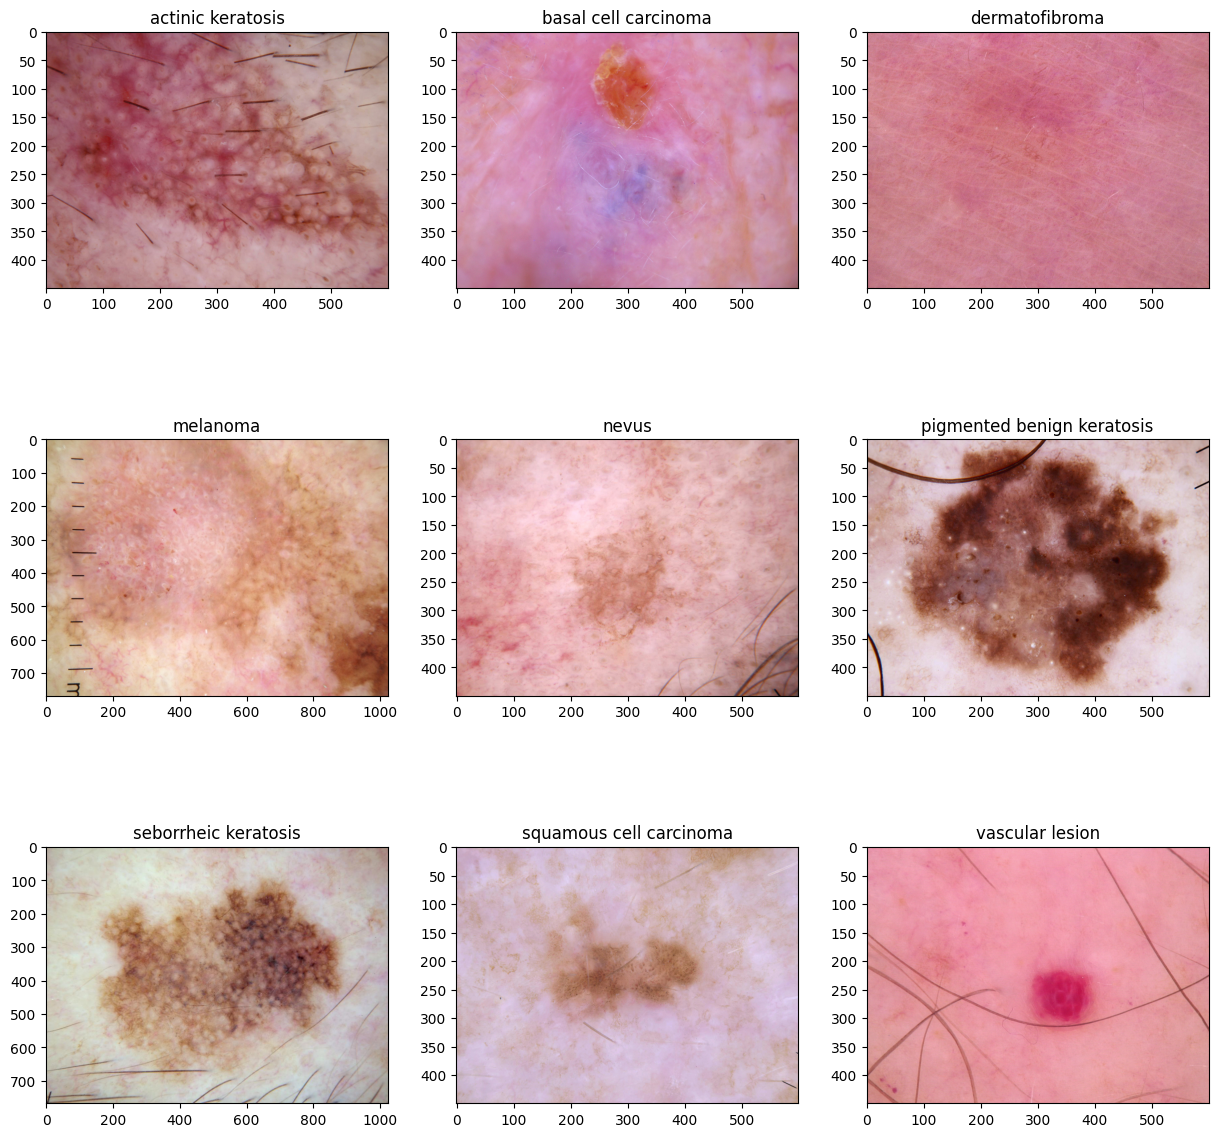

In [13]:
# visualizing one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
# method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model Building & training
1. Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2. Choosing an appropriate optimiser and loss function for model training
3. Training the model for ~20 epochs
4. Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

### Building the First Model

In [15]:
# configuring the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# CNN Model - Initial
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))


In [17]:
# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [19]:
# training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 126ms/step - loss: 2.1556 - accuracy: 0.2266 - val_loss: 1.8326 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7817 - accuracy: 0.3521 - val_loss: 1.7515 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.5902 - accuracy: 0.4481 - val_loss: 1.5618 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4933 - accuracy: 0.4782 - val_loss: 1.4912 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3620 - accuracy: 0.5195 - val_loss: 1.4073 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.2874 - accuracy: 0.5569 - val_loss: 1.3783 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.3029 - accuracy: 0.5312 - val_loss: 1.5033 - val_accuracy: 0.5168
Epoch 8/20


#### Visualizing training results

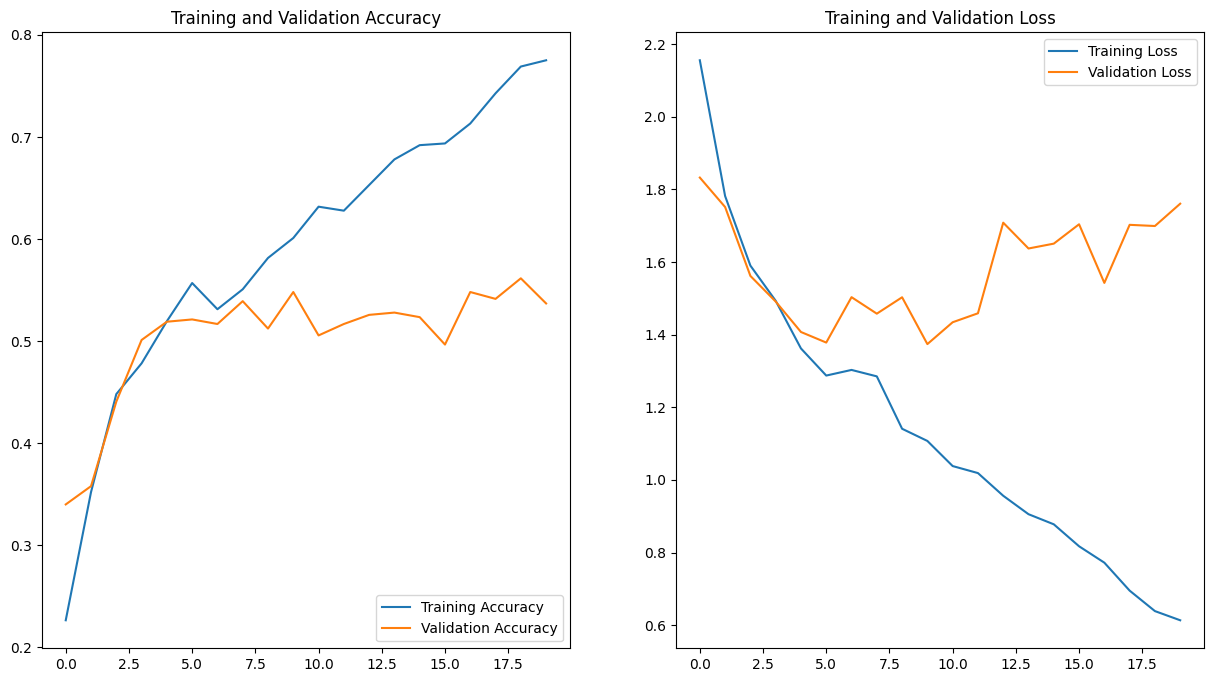

In [20]:
# calling the function to visualize the training results
plot_cnn_metrics(history, epochs)

#### Findings :

1.   As the number of epochs increase, the training accuracy increases whereas the validation accuracy increases to a max value of 50-55% and then stalls.
2.   As the number of epochs increase, the training loss decreases whereas the validation loss decreases in the start but later keeps on increasing.
3.   The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around 50-55% accuracy on the validation set.
4.   The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting and that's why the model needs tuning.

Overfitting can happen due to several reasons, such as:

1. The training data size is too small and does not contain enough data samples to accurately represent all possible input data values.
2. The training data contains large amounts of irrelevant information, also called noisy data.
3. The model trains for too long on a single sample set of data.
4. The model complexity is high, so it learns the noise within the training data.
5. For our model, looks like the training data is insufficient. So, let's try to perform some data augmentation strategy to come up with a bigger dataset
6. Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

### Building the Second Model

Choosing an appropriate data augmentation strategy to resolve overfitting

In [21]:
# performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

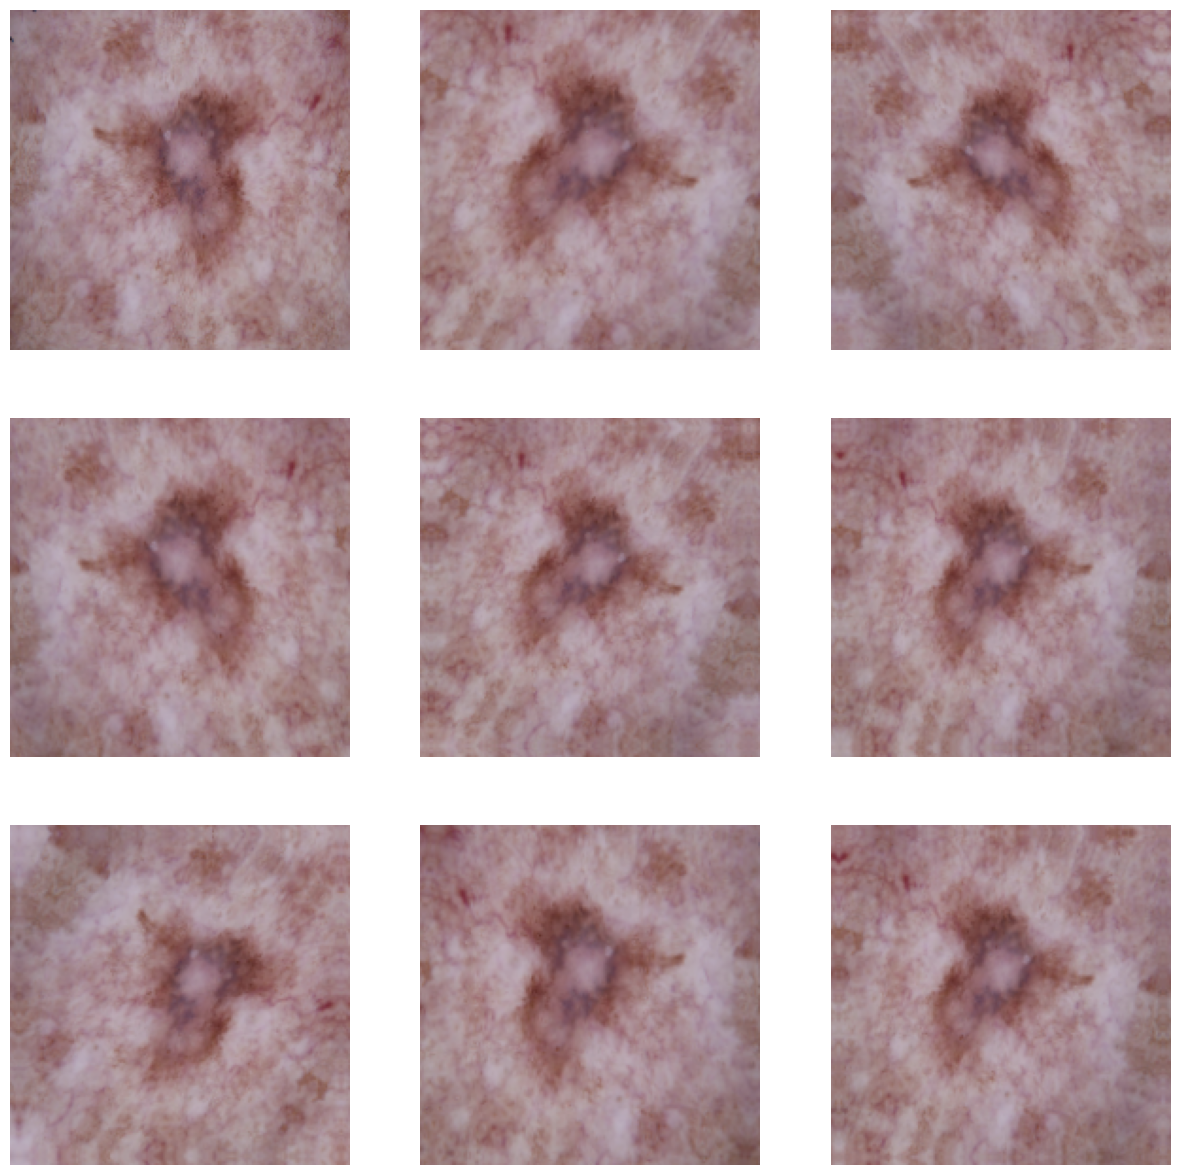

In [22]:
# visualizing the augmentation strategy for one instance of training image.
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Now, using this augmented data, let's come up with a new model

In [23]:
# using dropout layer for overfitting treatment
# CNN Model with data augmentation
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [24]:
# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [25]:
# training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 60ms/step - loss: 2.1337 - accuracy: 0.2400 - val_loss: 1.7542 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7331 - accuracy: 0.3627 - val_loss: 1.5550 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6520 - accuracy: 0.4107 - val_loss: 1.5154 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4995 - accuracy: 0.4732 - val_loss: 1.4208 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4576 - accuracy: 0.4833 - val_loss: 1.4803 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3820 - accuracy: 0.5050 - val_loss: 1.4072 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4126 - accuracy: 0.5067 - val_loss: 1.3585 - val_accuracy: 0.5235
Epoch 8/20
56

#### Visualizing the results

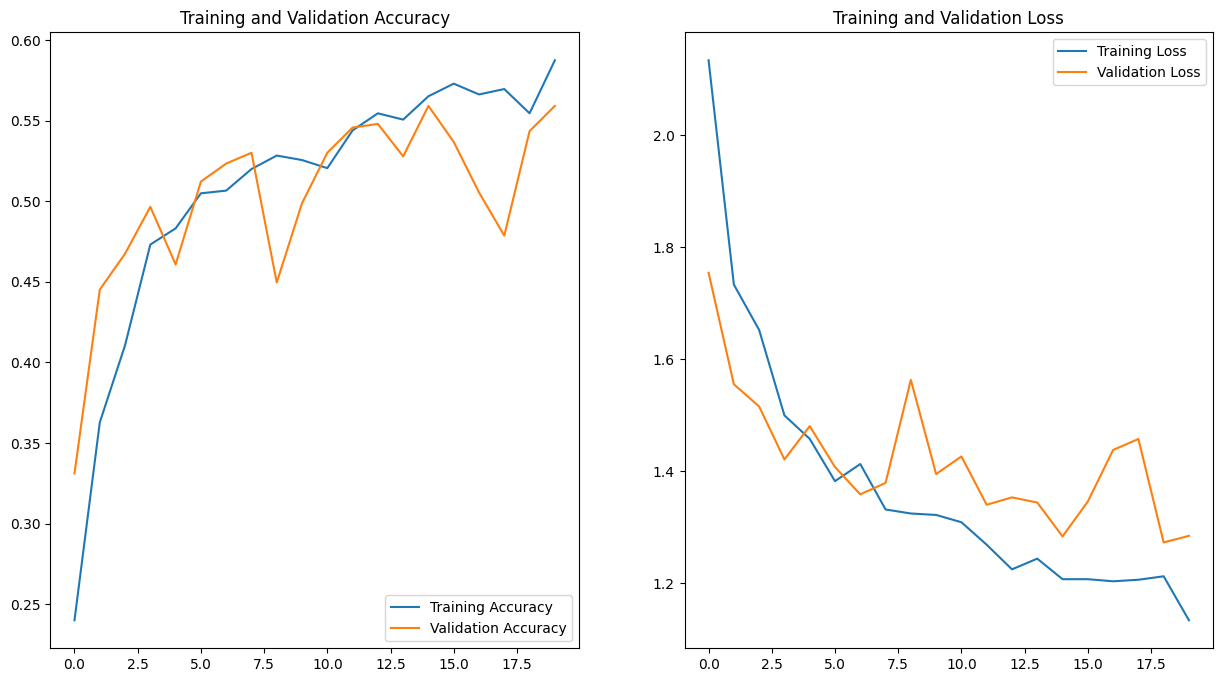

In [26]:
# calling the function to visualize the training results
plot_cnn_metrics(history, epochs)

#### Findings :
1. As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
2. As the training loss decreases with epochs the validation loss decreases.
3. The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is very less.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier model, but the overall accuracy isn't really great.**

### Building the third model

#### Class distribution:

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
# printing the number of records for each class
print("Number of samples for each class: ")
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


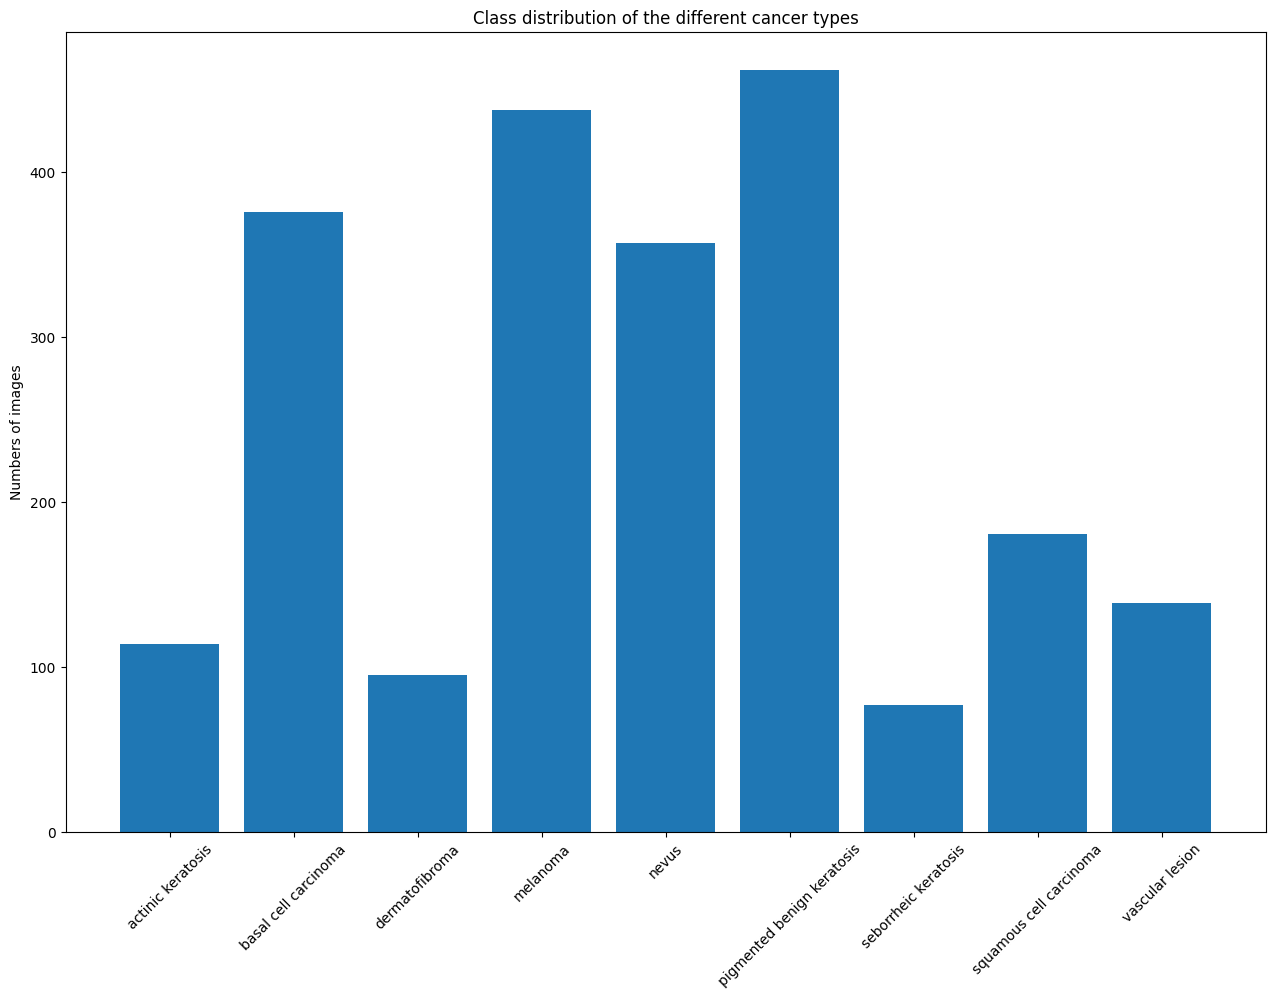

In [28]:
# ploting the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

#### Findings
1. Class imbalance is observed. It can be seen that some classes have proportionately higher number of samples compared to the others.
2. The class ***seborrheic keratosis*** has the least number of samples with just 77 images.
3. The class ***pigmented benign keratosis*** has the highest number of samples with 462 images.

#### Handling Class Imbalance

In [29]:
# rectifing class imbalances present in the training dataset with Augmentor library.
# installing augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
# adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3EC02C7430>: 100%|██████████| 500/500 [00:23<00:00, 21.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3EC02F2AD0>: 100%|██████████| 500/500 [00:23<00:00, 20.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E4D2C0490>: 100%|██████████| 500/500 [00:19<00:00, 25.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F3EC0157730>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F3E4D3FAA70>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3EC02F2B90>: 100%|██████████| 500/500 [00:20<00:00, 24.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3E4D1CFB50>: 100%|██████████| 500/500 [00:42<00:00, 11.85 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E4D342D70>: 100%|██████████| 500/500 [00:17<00:00, 27.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3EC2EBAE30>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]


Augmentor has stored the augmented 500 images in the output sub-directory of each of the sub-directories of skin cancer types.

In [31]:
# generated 500 images for every class in the output directory
# lets take a look at total count of augmented images.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
# list containing the path of all new 4500 images generated
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033817.jpg_52ccefe9-6b36-46d4-b0a8-5b7906010028.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_1350a4e9-387e-4dc7-8416-d51272374a70.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_6e77bcf2-fdd6-44eb-838e-964b2b207a9f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033158.jpg_a8a908cc-3216-4d1d-b362-dcaad594de1a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030882.jpg_363b992b-1321-4445-8699-c378877465ef.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collab

In [33]:
# list containing the class of all the 4500 images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [34]:
# printing the number of images for each class after class balancing
for i in class_names:
    directory ='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
    directory_out ='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


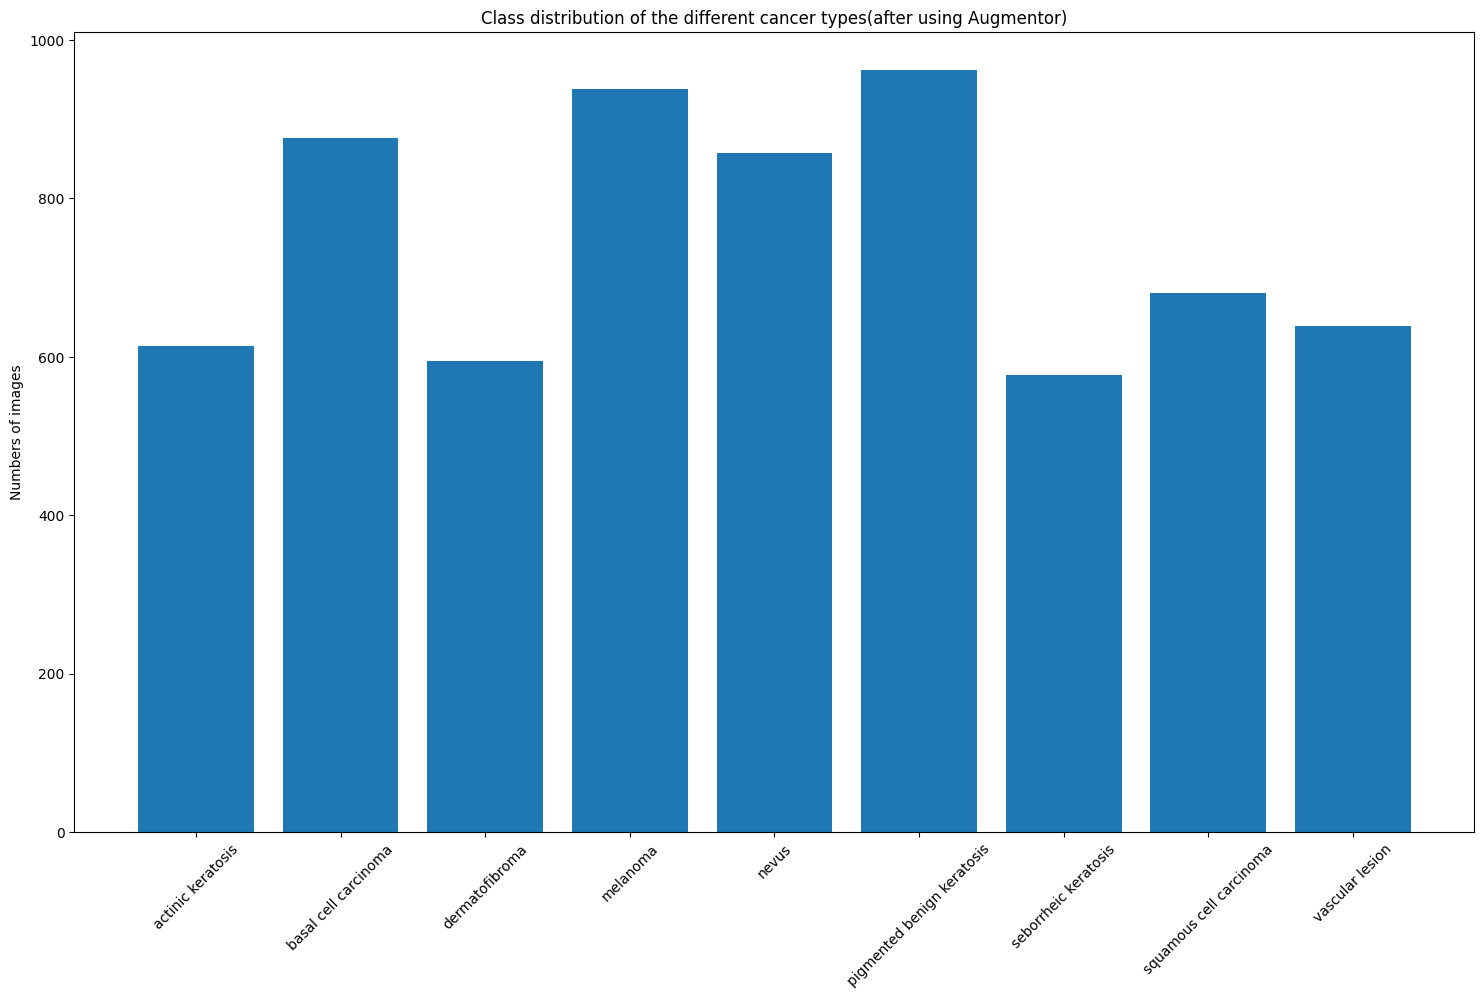

In [35]:
# ploting the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Creating a new train and test dataset

In [36]:
# defining some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
# loading the training data
# using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [38]:
# loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [39]:
# configuring the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model Building & training on the rectified class imbalance data
1. Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2. Choosing an appropriate optimiser and loss function for model training.
3. Training the model for ~30 epochs.
4. Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [40]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [41]:
# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [42]:
# training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 47s 95ms/step - loss: 2.1261 - accuracy: 0.2146 - val_loss: 2.0926 - val_accuracy: 0.2376
Epoch 2/30
169/169 [==============================] - 9s 55ms/step - loss: 1.6076 - accuracy: 0.3841 - val_loss: 1.3369 - val_accuracy: 0.4833
Epoch 3/30
169/169 [==============================] - 9s 55ms/step - loss: 1.3843 - accuracy: 0.4742 - val_loss: 1.2064 - val_accuracy: 0.5709
Epoch 4/30
169/169 [==============================] - 9s 55ms/step - loss: 1.2458 - accuracy: 0.5310 - val_loss: 1.0987 - val_accuracy: 0.6154
Epoch 5/30
169/169 [==============================] - 9s 56ms/step - loss: 1.1384 - accuracy: 0.5790 - val_loss: 1.0289 - val_accuracy: 0.6073
Epoch 6/30
169/169 [==============================] - 9s 56ms/step - loss: 0.9775 - accuracy: 0.6346 - val_loss: 0.9508 - val_accuracy: 0.6481
Epoch 7/30
169/169 [==============================] - 10s 56ms/step - loss: 0.9008 - accuracy: 0.6649 - val_loss: 0.8381 - val_accuracy: 0.69

#### Visualizing the results

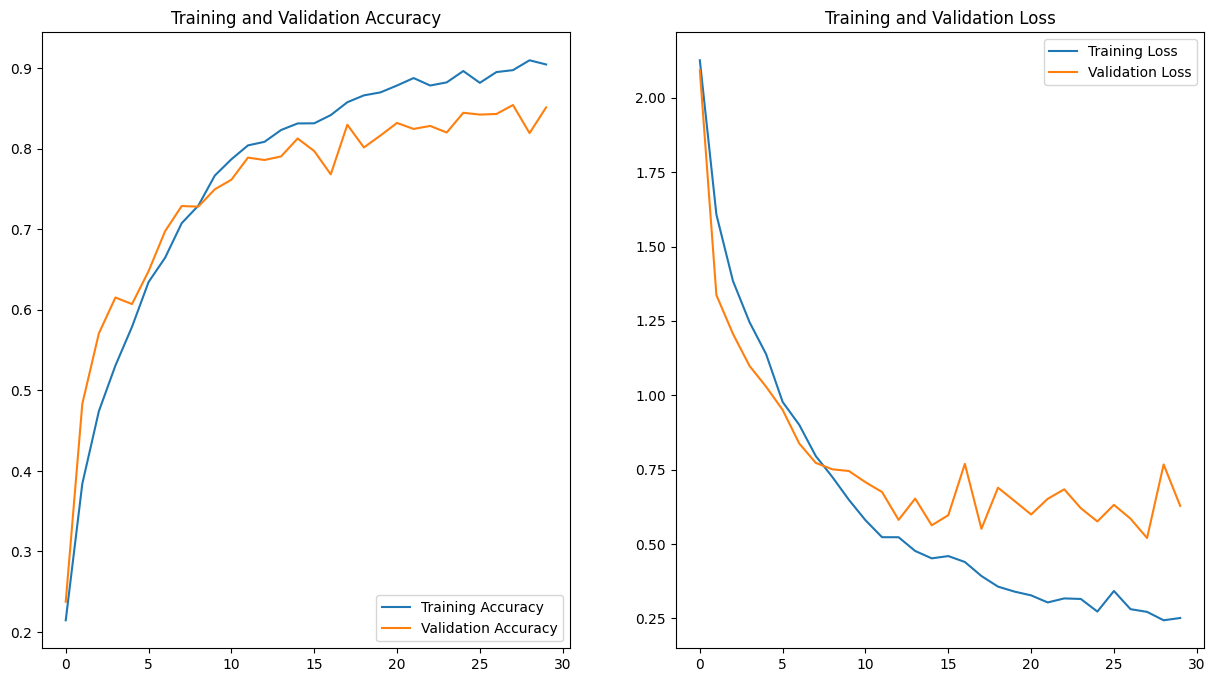

In [43]:
# calling the function to visualize the training results
plot_cnn_metrics(history, epochs)

#### Result Analysis

1. As the training accuracy increases with epochs the validation accuracy also increases in the training process.
2. As the training loss decreases with epochs the validation loss also decreases.
3. The plots show that gap between training accuracy and validation accuracy has decreased significantly from the previous model, it is a sign of a good fit.
4. The model has achieved around 85% accuracy on the validation set. Thus, it will be able to classify the images with 85% accuracy.
5. Class rebalancing improved the overall accuracy and also reduced the overall loss.

### Model Testing

1/1 [==============================] - 0s 192ms/step
Actual Class: vascular lesion
Predictive Class: vascular lesion


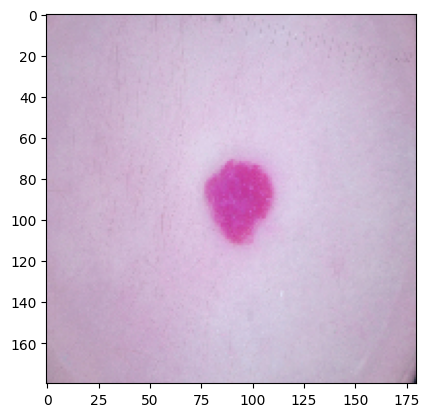

In [44]:
# testing the model on test data after preprocessing
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
# intializing the test image directory for a particular class
Test_image = glob(Test_image_path)
# loading a particular image
Test_image = load_img(Test_image[1],target_size=(img_height,img_width,3))
# plotting the image
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

# predicting using the preprocessed image
pred = model.predict(img)
pred = np.argmax(pred)
# predicting the class
pred_class = class_names[pred]
# comparing the actual and predicted class
print(f"Actual Class: {class_names[8]}" + '\n' + "Predictive Class: " + pred_class)